In [3]:
import theano as T
import theano.tensor as TT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Theano for Arbitrary Optimizations

#### What's Theano?
Theano is a Python package which can broadly be described as 'easy Tensorflow, with less features'. It was designed to let the user define, optimize, and evaluate mathematical expressions. What's special about Theano?

**Pros:**
* It's just about the fastest you can get coding in Python.
    * Automatically simplifies math expressions. Evaluating $y = y^2/y$ doesn't do any work, for example.
    * Compiles some expressions to CPU instructions via gcc
    * Optimizes computation graph (merges redundant instructions, etc)
    * It can use CUDA and other GPU toolkits
* Because of its symbolic approach, some math is really easy to implement (today, we're going to cover SGD).
* Has really good autodiff. Applies chain rule directly to entire instruction sequence, which means that you can find derivatives with indirect references REALLY QUICKLY. For example:

In [4]:
a = TT.scalar()
b = a + 2
c = 2*b + 3
T.grad(c, a).eval({a:1})

array(2.)

**Cons:**

* You might have noticed it's a lot more verbose and harder to write than ordinary Python code. Variables and functions have to be initialized as abstract Theano tensors (not statically typed, but more statically typed than most Python), and you have to go to somewhat more lengths to start pushing numbers through them.
* It's not going to be a bunch of fun to play with in the interpreter, because everything that's initialized has to be added to the computation graph, compiled, and cached for later.
* It's pretty hard to debug.

In [275]:
x = TT.dscalar()
y = TT.dscalar()
z = TT.pow(x, y)
print(z)
print(z/2) #Printing tensor objects only shows their most recent operation.

Elemwise{pow,no_inplace}.0
Elemwise{true_div,no_inplace}.0


### Remember Calculus?

Let's say we want to optimize some function $f(x)$. Recall that Fermat's theorem says that if a function is differentiable, then all of its extrema occur at $f'(x) = 0$ (these can be local or global).  

For example, if we want to find the minimum of $f(x) = x^{3} - 2x^{2}$, we take the derivative:
$f'(x) = 3x^{2} - 4x$, and solve the quadratic $0 = 3x^{2} - 4x$
$x = \frac{4 \pm 4}{6} = \frac{8}{6}, 0$

Below we can see a graph of the function in blue, and its first derivative in orange. We can see that the is zero at the same time as the function achieves its local minimum.

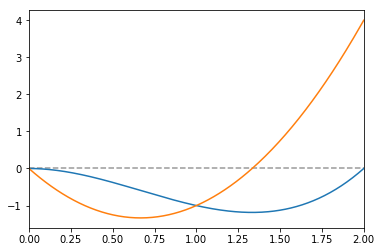

In [402]:
x_pts = np.linspace(0,2,300)
f_pts = x_pts**3 - 2*x_pts**2
fp_pts = 3*x_pts**2 - 4*x_pts
plt.plot(x_pts, f_pts)
plt.plot(x_pts, fp_pts)
plt.hlines(y = 0, xmin=-1, xmax=2.5, linestyle = '--', alpha = 0.4)
plt.xlim(0, 2);

### How does this differ for functions of more than one variable?

Surprisingly, not that much. Instead of the derivative $f'(x)$, for functions $f(x, y)$ we use the _gradient_, $\nabla f(x,y)$, which is the vector of derivatives in each variable $f$ is in: $$ \nabla f(x,y) = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right)^{T}$$

Similarly (for smooth functions), the maxima of $f$ occur when its gradient is the zero vector. When $f$ is sufficiently smooth and we want to minimize it, we don't have to directly solve $\nabla f(x,y) = \mathbf{0}$. Instead, we can use an algorithm called _gradient descent_. Gradient descent uses the fact that the gradient, when interpreted as a vector and scaled, points to the _direction of steepest ascent_.

### Example (With Theano):

Let $f(x,y) = x - \log(x) + y - \log(y)$. Below, we'll define $f$ as a Theano function, and then plot its values in a heatmap and its gradient as a vector field over the heatmap.

To define a theano function, we first need to define its constituent inputs as tensor variables. Tensor variables are placeholder objects for arrays which have static types. Basic math operations (+, -, \*, abs) are overloaded from Python syntax for convenience, but pretty much anything fancier than that has to be done as an operation with the theano.tensor module. 

In [412]:
x = TT.dscalar()
y = TT.dscalar()
f = x - TT.log10(x) + y - TT.log10(y) #Done! What happens if we evaluate f?

In [414]:
f(1,2) #Whoops, this isn't callable.

TypeError: 'TensorVariable' object is not callable

In order to actually use these tensor variables as functions, there are two options. 

* Define it as a function with theano.function(f, inputs, outputs)
* Use f.eval({arg1: value1, arg2:value2, ...})

There are advantages to each, using theano.function lets you define things like updates to shared variables and input behavior, but f.eval is more convenient for what we're doing now. A little bit of ugly code is required also, because I need to evaluate this function on a grid later. np.frompyfunc(f, n_in, n_out) lets you make a function that applies itemwise to arrays in the way you would expect.

In [427]:
print(f.eval({x:1, y:2}))
f_py = np.frompyfunc(lambda a,b: f.eval({x:a, y:b}), 2, 1)
#This sort of ugly workaround is because I have to evaluate f on a grid later.

2.6989700043360187


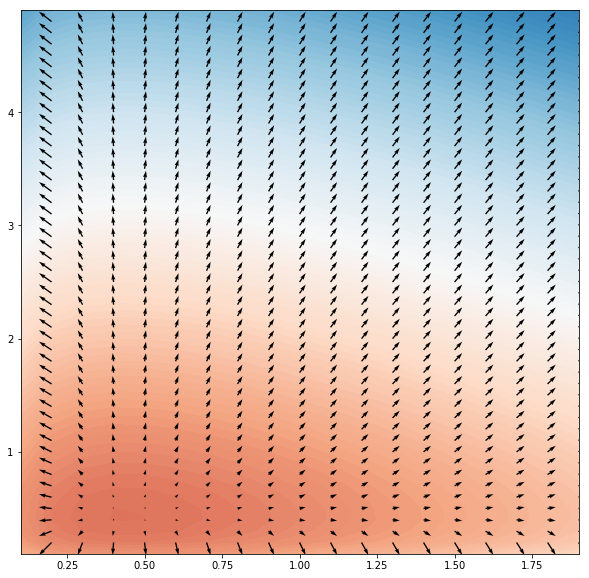

In [428]:
def plot_grads():
    xx, yy = np.meshgrid(np.arange(0.1,2,0.1), np.arange(0.1,5,0.1))
    zz = f_py(xx, yy)
    fig = plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, zz, levels = np.arange(0,7,0.05), cmap = 'RdBu')

    xx, yy = np.meshgrid(np.arange(0.2,2,0.1), np.arange(0.2,5,0.1))

    grad_py_x_1 = lambda a, b :T.grad(f, x).eval({x:a, y:b})
    grad_x_py = np.frompyfunc(grad_py_x_1, 2, 1)

    grad_py_y_1 = lambda a, b :T.grad(f, y).eval({x:a, y:b})
    grad_y_py = np.frompyfunc(grad_py_y_1, 2, 1)

    uu = np.array(grad_x_py(xx, yy).tolist()) 
    vv = np.array(grad_y_py(xx, yy).tolist())
    plt.quiver(xx, yy, uu, vv)

plot_grads()

### Implementing GD for this function

So, you'll notice in the graph above that the gradient arrows always point away from the minimum. What if we just went in the opposite direction of the arrows? This idea is called _gradient descent,_ and it's really quite simple. We pick some learning rate $\eta$, and at each step we multiply the learning rate with the negative gradient and progress in that direction.
$$\mathbf{x}_{i} = \mathbf{x}_{i-1} - \eta \cdot \nabla f(\mathbf{x}_{i-1})$$
    

In [ ]:


def SGD(tol, n_iter):
    #Stochastic gradient descent. Minimizes function f, using n_iter and tol stopping criteria
    #f needs to have one parameter, xy, with 2 entries
    #Returns a list of x, y, error at each step.
    xy = T.shared(np.array([1.7, 5]))
    error_f = xy[0] - TT.log10(xy[0]) + xy[1] - TT.log10(xy[1])
    d_loss_wrt_params = T.grad(error_f, xy)
    updates = [(xy, xy - 0.1 * d_loss_wrt_params)]
    SGD = T.function([], error_f, updates=updates)
    error_list = [0]
    xylist = []
    ct = 0
    error_list[0] = SGD()
    while True:
        ct += 1
        error_list.append(SGD())
        xylist.append(xy.get_value().tolist())
        if (abs(error_list[ct] - error_list[ct-1]) < tol) | (ct > n_iter):
            break
    return np.array(xylist)
    

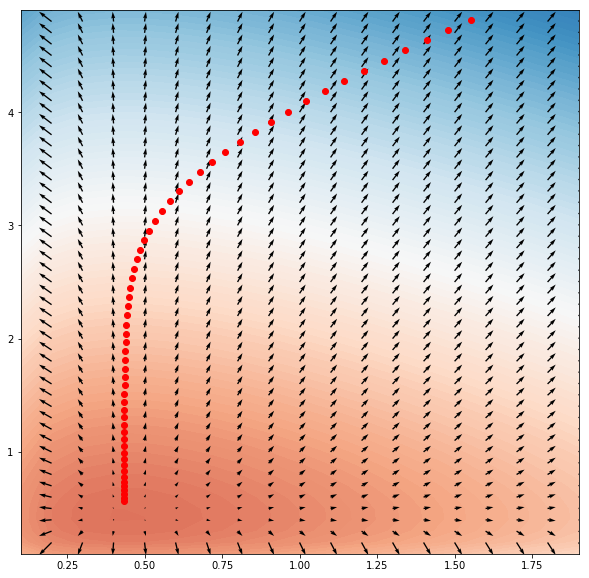

In [429]:
GP = plot_grads()
xylist = SGD(0.01, 500)
plt.scatter(xylist[:,0], xylist[:,1], color = 'r')

1.6100423144120128